## Benchmarking for LightAutoML

### Purpose: compare default and tuned models with LightAutoML preformance

The following models will be used, with default setting and also with hyperparameter tuning
1. Linear Regression (just 'default')
2. Random Forest
3. LightGBM
4. CatBoost
5. LightAutoML

### What is LightAutoML?

<img src="https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/imgs/LightAutoML_logo_big.png" width="500"/>

Russian Sberbank's AI Lab's AutoML library, open sourced on GitHub: https://github.com/sberbank-ai-lab/LightAutoML
Online course (in Russian): https://courses.sberuniversity.ru/lightautoml

Using linear models, LightGBM and CatBoost, LightAutoML builds models and applies a blender (stacker) on them. Any number of levels can be built.

<!-- <img src="https://miro.medium.com/proxy/1*VdoX78-sv4wThpGxpCSmnQ.png" width="800"/> -->
<img src="https://raw.githubusercontent.com/sberbank-ai-lab/lightautoml-datafest-workshop/88e5a53824ff6466c3ac6514708775beefc598ca/imgs/tutorial_blackbox_pipeline.png" width="900"/>


Some tutorials:
- (Russian) https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop/blob/master/LightAutoML%20demo%20(Blackbox).ipynb
- (English) https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb
- (English) https://www.kaggle.com/alexryzhkov/lightautoml-titanic-love
- (English) https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936

In [1]:
import calendar
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import pickle

import warnings
warnings.filterwarnings('ignore')

def plot_corr(df, numerics):
    
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.heatmap(df[numerics].corr(), ax = ax, cmap = 'coolwarm', center = 0, 
                annot = True, fmt = '.2g', annot_kws={'size' : 10})
    plt.title('Correlations\n')
    plt.show()
    
def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y, automl = False):
    
    predictions = model.predict(X)
    
    if automl:
        predictions = predictions.data[:,0]

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)
    R2 = r2_score(y, predictions)

    return pd.DataFrame({'Model' : model_name, 'r2' : R2, 'RMSE' : RMSE, 'MAE' : MAE, 'MAPE' : MAPE}, index = [0])

def plot_feat_imp(feat_scores_object):

    plt.figure(figsize = (9, 4))
    sns.barplot(data = feat_scores_object, x = 'Importance', y = 'Feature', 
                color = '#89bedc', edgecolor = 'black', linewidth = 1/2)
    plt.title('LightAutoML feature importances')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

In [2]:
RANDOM_STATE = 56

### Information about dataset:

Bike sharing dataset from UCI: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- mnth : month ( 1 to 12)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- cnt: count of total rental bikes including both casual and registered

For LightAutoML benchmarking purposes it's ideal: (1) small, (2) pretty clean, (3) has categorical features

In [3]:
data = pd.read_csv('data/day.csv', index_col = 0)
data.drop(['dteday', 'yr', 'casual', 'registered', 'temp'], 1, inplace = True)

season_mapper = {1 : 'Spring', 2 : 'Summer', 3 : 'Fall', 4 : 'Winter'}
data['season'].replace(season_mapper, inplace = True)

month_mapper = dict(zip([i for i in range(0, 13)], [i for i in calendar.month_abbr]))
data['mnth'].replace(month_mapper, inplace = True)

day_mapper = dict(zip([1, 2, 3, 4, 5, 6, 0], [i for i in calendar.day_abbr]))
data['weekday'].replace(day_mapper, inplace = True)

weather_mapper = {1 : 'Clear', 2 : 'Cloudy', 3 : 'Light Precip', 4 : 'Heavy Precip'}
data['weathersit'].replace(weather_mapper, inplace = True)

In [4]:
data.shape

(731, 10)

In [5]:
data.head(3)

,season,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
instant,,,,,,,,,,
1,Spring,Jan,0,Sat,0,Cloudy,0.363625,0.805833,0.160446,985
2,Spring,Jan,0,Sun,0,Cloudy,0.353739,0.696087,0.248539,801
3,Spring,Jan,0,Mon,1,Clear,0.189405,0.437273,0.248309,1349


### Preprocessing

Minimal feature engineering
- Check missing values
- Check distribution
- Check correlation
- OHE ShelveLoc for models that cannot treat categoricals
    - will use OHEd dataset for Linear Regression, RF
    - will use original categorical for LightGBM, CatBoost and LightAutoML

In [6]:
all(data.isnull().sum() == 0)

True

In [7]:
data.describe(percentiles = [.01, .1, .25, .5, .75, .9, .99]).T.round(2)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
holiday,731.0,0.03,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
workingday,731.0,0.68,0.47,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
atemp,731.0,0.47,0.16,0.08,0.15,0.26,0.34,0.49,0.61,0.68,0.78,0.84
hum,731.0,0.63,0.14,0.00,0.31,0.45,0.52,0.63,0.73,0.82,0.93,0.97
windspeed,731.0,0.19,0.08,0.02,0.05,0.10,0.13,0.18,0.23,0.30,0.41,0.51
cnt,731.0,4504.35,1937.21,22.00,689.60,1746.00,3152.00,4548.00,5956.00,7290.00,8163.70,8714.00


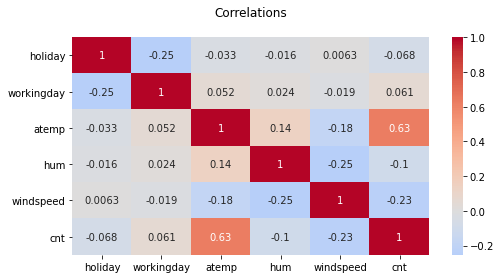

In [8]:
plot_corr(data, data.select_dtypes(exclude = 'O').columns)

In [9]:
categoricals = data.select_dtypes('O').columns.tolist()

In [10]:
data_OHE = pd.get_dummies(data, columns = categoricals, prefix_sep = ' = ')
data_OHE.drop(['weathersit = Light Precip', 'season = Fall', 'weekday = Mon', 'mnth = Oct'], 1, inplace = True)

### Split data

In [11]:
TARGET = 'cnt'

X = data.drop(TARGET, 1).copy()
X_OHE = data_OHE.drop(TARGET, 1).copy()

y = data[TARGET].copy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = RANDOM_STATE)
X_OHE_train, X_OHE_test, _, _ = train_test_split(X_OHE, y, train_size = .8, random_state = RANDOM_STATE)

### Apply ML models
#### 1. Linear Regression

In [190]:
LR = LinearRegression().fit(X_OHE_train, y_train)
LR_results = evaluate_model('Linear Regression', LR, X_OHE_test, y_test)

#### 2. Random Forest (defeault)

In [191]:
RF = RandomForestRegressor(n_jobs = -1, random_state = RANDOM_STATE).fit(X_OHE_train, y_train)
RF_results = evaluate_model('Random Forest (default)', RF, X_OHE_test, y_test)

#### 3. Random Forest (tuned)

In [124]:
%%time

RF_params = {'max_depth' : [9, 11], 
             'min_samples_split' : [5],  
             'min_samples_leaf' : [3], 
             'max_features' : [1/2, 2/3, 3/4],
             'n_estimators' : [300]}

RF = RandomForestRegressor(random_state = RANDOM_STATE, n_jobs = -1)

GRID_RF = GridSearchCV(RF, param_grid = RF_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
GRID_RF.fit(X_OHE_train, y_train)

Wall time: 6.73 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=56),
             n_jobs=-1,
             param_grid={'max_depth': [9, 11],
                         'max_features': [0.5, 0.6666666666666666, 0.75],
                         'min_samples_leaf': [3], 'min_samples_split': [5],
                         'n_estimators': [300]},
             scoring='neg_root_mean_squared_error')

In [126]:
RF_GRID_results = evaluate_model('Random Forest (tuned)', GRID_RF.best_estimator_, X_OHE_test, y_test)

#### 4. LightGBM (default)

In [192]:
LGB = LGBMRegressor(random_state = RANDOM_STATE, 
                    objective = 'root_mean_squared_error', 
                    metric = 'root_mean_squared_error').fit(X_OHE_train, y_train)
LGB_results = evaluate_model('LightGBM (default)', LGB, X_OHE_test, y_test)

#### 5. LightGBM (tuned)

In [241]:
%%time

LGB_params = {'boosting_type' : ['goss', 'gbdt'],
              'learning_rate' : [0.05],
              'num_leaves' : [7],
              'min_child_samples' : [11],
              'max_depth' : [7],
              'subsample' : [1],
              'colsample_bytree' : [3/4],
              'n_estimators' : [75]}

LGB = LGBMRegressor(random_state = RANDOM_STATE, 
                    objective = 'root_mean_squared_error', 
                    metric = 'root_mean_squared_error')
GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
GRID_LGB.fit(X_OHE_train, y_train)

Wall time: 147 ms


GridSearchCV(cv=3,
             estimator=LGBMRegressor(metric='root_mean_squared_error',
                                     objective='root_mean_squared_error',
                                     random_state=56),
             n_jobs=-1,
             param_grid={'boosting_type': ['goss', 'gbdt'],
                         'colsample_bytree': [0.75], 'learning_rate': [0.05],
                         'max_depth': [7], 'min_child_samples': [11],
                         'n_estimators': [75], 'num_leaves': [7],
                         'subsample': [1]},
             scoring='neg_root_mean_squared_error')

In [244]:
LGB_GRID_results = evaluate_model('LightGBM (tuned)', GRID_LGB.best_estimator_, X_OHE_test, y_test)

#### 6. CatBoost (default)

In [253]:
CB = CatBoostRegressor(random_state = RANDOM_STATE, eval_metric = 'RMSE', objective = 'RMSE',
                       cat_features = categoricals, verbose = 0).fit(X_train, y_train)
CB_results = evaluate_model('CatBoost (default)', CB, X_test, y_test)

#### 7. CatBoost (tuned)

In [367]:
%%time

cat_params = {'learning_rate': [0.01],
              'l2_leaf_reg': [1],
              'subsample': [.8],
              'rsm' : [1/2],
              'max_depth': [9], # up to 16 
              'grow_policy': ['Lossguide'], #, 'SymmetricTree', 'Depthwise'
              'min_data_in_leaf' : [15], 
              'max_leaves' : [11],
              'one_hot_max_size' : [5],
              'iterations' : [1000]} 

cat = CatBoostRegressor(random_state = RANDOM_STATE, eval_metric = 'RMSE', objective = 'RMSE',
                        cat_features = categoricals, verbose = 0)

GRID_cat = GridSearchCV(cat, param_grid = cat_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
GRID_cat.fit(X_train, y_train)

Wall time: 1min 31s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001D3CB42D730>,
             n_jobs=-1,
             param_grid={'grow_policy': ['Lossguide'], 'iterations': [1000],
                         'l2_leaf_reg': [1], 'learning_rate': [0.01],
                         'max_depth': [9], 'max_leaves': [11],
                         'min_data_in_leaf': [15], 'one_hot_max_size': [5],
                         'rsm': [0.5], 'subsample': [0.8]},
             scoring='neg_root_mean_squared_error')

In [368]:
CB_GRID_results = evaluate_model('CatBoost (tuned)', GRID_cat.best_estimator_, X_test, y_test)

### Compare models built so far - peformances are calculated on test set

In [370]:
results = pd.concat([LR_results, 
                     RF_results, 
                     RF_GRID_results, 
                     LGB_results, 
                     LGB_GRID_results,
                     CB_results,
                     CB_GRID_results]).sort_values('RMSE')
results

,Model,r2,RMSE,MAE,MAPE
0,Random Forest (tuned),0.582087,1237.865199,1069.528417,28.051760
0,CatBoost (tuned),0.579263,1242.040713,1081.442023,27.705847
0,LightGBM (tuned),0.569335,1256.608811,1094.171345,28.637821
0,CatBoost (default),0.564596,1263.504282,1080.628645,27.179839
0,Random Forest (default),0.559479,1270.907274,1085.378163,28.276113
0,Linear Regression,0.517106,1330.626777,1183.931973,31.766967
0,LightGBM (default),0.505294,1346.802943,1128.937071,28.277523


Takeaways:
1. Tuned models perform better than default models
2. Of the default models CatBoost is best, LightGBM is worst
3. Overall best is tuned Random Forest

Now let's see what LightAutoML can achieve. Applying the default models and tuning them took around ~3 hours overall. I will set a time limit for the AutoML model and see how good of a model it can build in such period.

### Running LightAutoML

In [13]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [14]:
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 600

Specify Task object - what is the objective? (https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html)

In [15]:
task = Task('reg', loss = 'mse', metric = 'mse')

Specify roles - what are our feature types? (https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)

In [16]:
roles = {
    
    #'drop': ['Id'],
    'target': TARGET,
    #'numeric' : ,
    'category' : categoricals,

}

LightAutoML doesn't need X-y split

In [17]:
train = pd.concat([X_train, y_train], 1)
test = pd.concat([X_test, y_test], 1)

#### Create trainer #1: default automl model

In [18]:
automl = TabularAutoML(task = task, 
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})

Fit and predict

In [594]:
%%time
oof_pred = automl.fit_predict(train, roles = roles)

Wall time: 1min 53s


In [65]:
# how to reach actual model:
automl.levels[0][1].ml_algos[1].models[0].params

{'task': 'train',
 'learning_rate': 0.05,
 'num_leaves': 186,
 'feature_fraction': 0.5219198222302963,
 'bagging_fraction': 0.6777417573880359,
 'bagging_freq': 1,
 'max_depth': -1,
 'verbosity': -1,
 'reg_alpha': 0.0010708391025277206,
 'reg_lambda': 0.012272526528401703,
 'min_split_gain': 0.0,
 'zero_as_missing': False,
 'num_threads': 4,
 'max_bin': 255,
 'min_data_in_bin': 3,
 'random_state': 42,
 'min_sum_hessian_in_leaf': 0.32606538739736407,
 'objective': 'regression',
 'metric': 'mse',
 'num_class': 1}

Check OOF performance - for AutoML, instead of train performance we need to check OOF performance (validation-like set)

In [435]:
mean_squared_error(oof_pred.target, oof_pred.data[:,0], squared = False)

1133.3989046924692

Calculate test performance

In [436]:
AUTOML_DEFAULT_RESULTS = evaluate_model('AutoML (default train time)', automl, test, test[TARGET], automl = True)

#### Create trainer #2: force 10 minutes of training time

In [457]:
automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})

Fit, predict, check performances

In [458]:
%%time
oof_pred = automl.fit_predict(train, roles = roles)

Wall time: 8min 1s


In [459]:
mean_squared_error(oof_pred.target, oof_pred.data[:,0], squared = False)

1147.020985551855

In [460]:
AUTOML_UTILIZED_RESULTS = evaluate_model('AutoML (10 minutes)', automl, test, test[TARGET], automl = True)

#### Create trainer #3: add catboost_default, add second level l2 and lgb models, set to 20 minutes

In [530]:
automl = TabularUtilizedAutoML(task = task, 
                               timeout = 60 * 20,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb'], ['linear_l2', 'lgb']]})

Fit, predict, check performances

In [531]:
%%time
oof_pred = automl.fit_predict(train, roles = roles)

Wall time: 18min 34s


In [532]:
mean_squared_error(oof_pred.target, oof_pred.data[:,0], squared = False)

1124.9682922449836

In [533]:
AUTOML_UTILIZED_MULTILEVEL_RESULTS = evaluate_model('AutoML (20 minutes, multilevel)', automl, test, test[TARGET], automl = True)

#### Create trainer #4: add catboost_tuned to 1st level and set 1 hour

In [648]:
automl_long = TabularUtilizedAutoML(task = task, 
                               timeout = 60 * 60,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned'], ['linear_l2', 'lgb']]})

In [649]:
%%time
oof_pred = automl_long.fit_predict(train, roles = roles)

Wall time: 56min 3s


In [650]:
mean_squared_error(oof_pred.target, oof_pred.data[:,0], squared = False)

1115.886763045505

In [651]:
AUTOML_UTILIZED_MULTILEVEL_LONG_RESULTS = evaluate_model('AutoML (1hr, multilevel)', automl_long, test, test[TARGET], automl = True)

### Compare final results

In [655]:
final_results = pd.concat([results, 
                           AUTOML_DEFAULT_RESULTS,
                           AUTOML_UTILIZED_RESULTS,
                           AUTOML_UTILIZED_MULTILEVEL_RESULTS,
                           AUTOML_UTILIZED_MULTILEVEL_LONG_RESULTS]).sort_values('RMSE')
final_results.reset_index(drop = True, inplace = True)

final_results.style \
    .highlight_max('r2', color = 'lightgreen') \
    .highlight_min('r2', color = 'red')\
    .highlight_max(['RMSE', 'MAE', 'MAPE'], color = 'red')\
    .highlight_min(['RMSE', 'MAE', 'MAPE'], color = 'lightgreen')\
    .where(lambda val: 'AutoML' in str(val), 'background-color: yellow', subset=['Model'])

,Model,r2,RMSE,MAE,MAPE
0,"AutoML (1hr, multilevel)",0.582715,1236.934613,1088.505232,27.608396
1,"AutoML (20 minutes, multilevel)",0.582589,1237.121003,1090.139478,27.764973
2,Random Forest (tuned),0.582087,1237.865199,1069.528417,28.051760
3,AutoML (10 minutes),0.581427,1238.842395,1093.143252,28.615964
4,AutoML (default train time),0.580046,1240.883736,1090.435306,28.441077
5,CatBoost (tuned),0.579263,1242.040713,1081.442023,27.705847
6,LightGBM (tuned),0.569335,1256.608811,1094.171345,28.637821
7,CatBoost (default),0.564596,1263.504282,1080.628645,27.179839
8,Random Forest (default),0.559479,1270.907274,1085.378163,28.276113
9,Linear Regression,0.517106,1330.626777,1183.931973,31.766967


## Open LightAutoML model

Model structure - default

In [475]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.75295 * 1 averaged models with config = "C:\Users\krist\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.34495 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.50553 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.14952 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


	+ 0.24705 * 1 averaged models with config = "C:\Users\krist\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.35957 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.34028 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.30015 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 





Model structure - 2 levels with CatBoost, Catboost tuned

In [656]:
print(automl_long.create_model_str_desc())

Final prediction for new objects = 
	0.27090 * 2 averaged models with config = "C:\Users\krist\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
			 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

		Final prediction for new objects (level 1) = 
			 0.34038 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
			 0.65962 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 


	    Model #1.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
			 5 averaged models Lvl_0_Pip

Feature importances

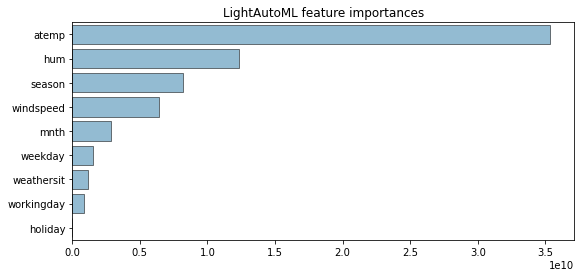

In [483]:
plot_feat_imp(automl.get_feature_scores())

Partial Dependency Plots

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.10it/s]


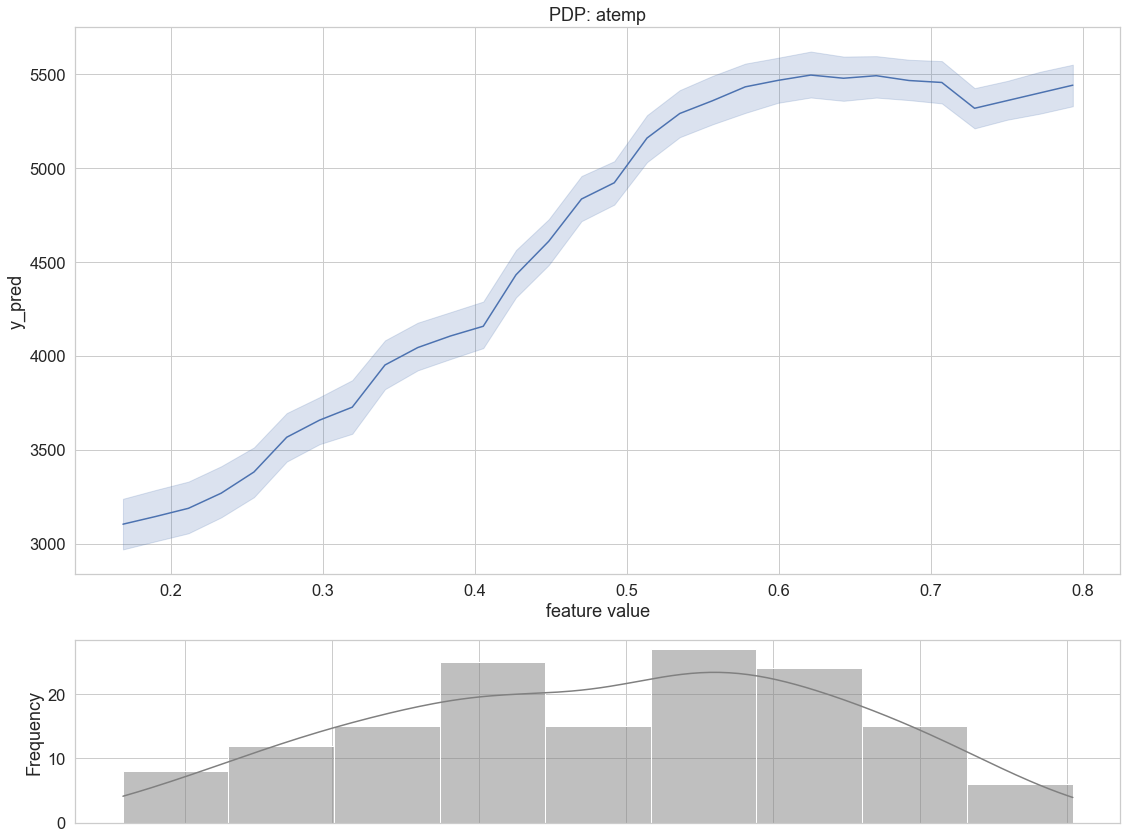

In [493]:
automl.plot_pdp(test, feature_name = 'atemp')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.89it/s]


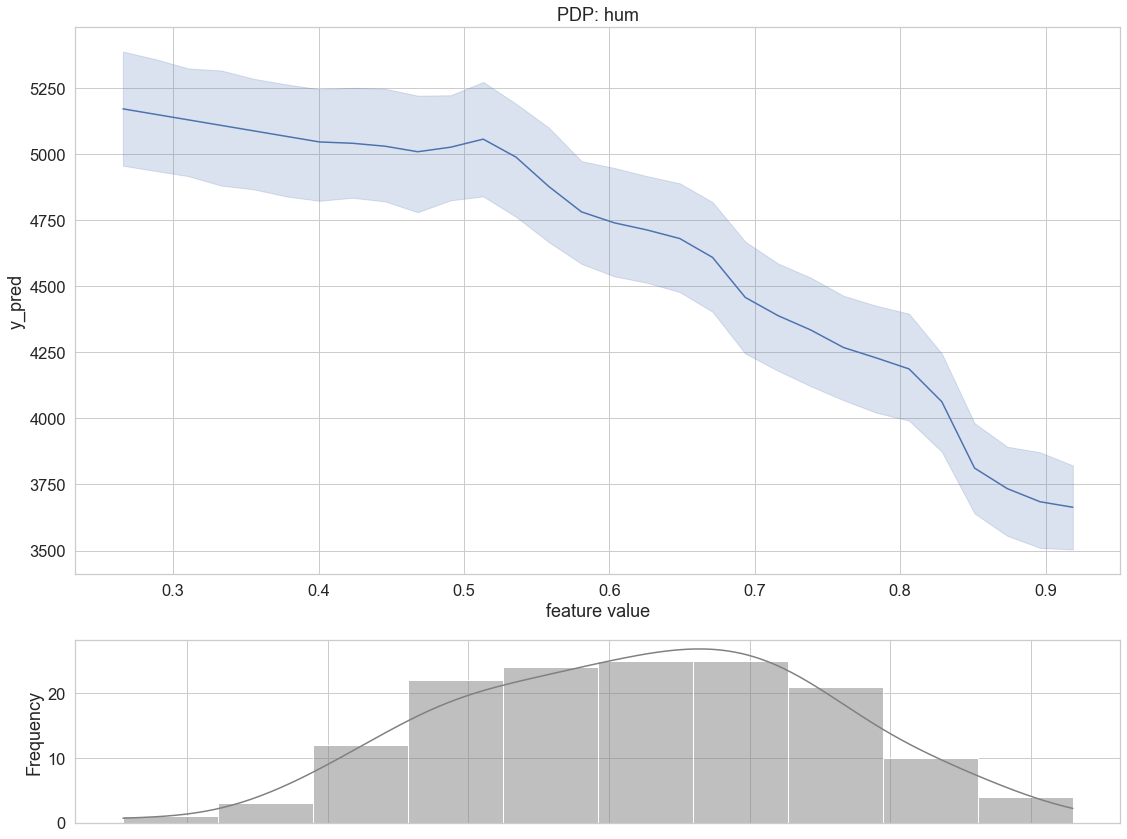

In [494]:
automl.plot_pdp(test, feature_name = 'hum')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


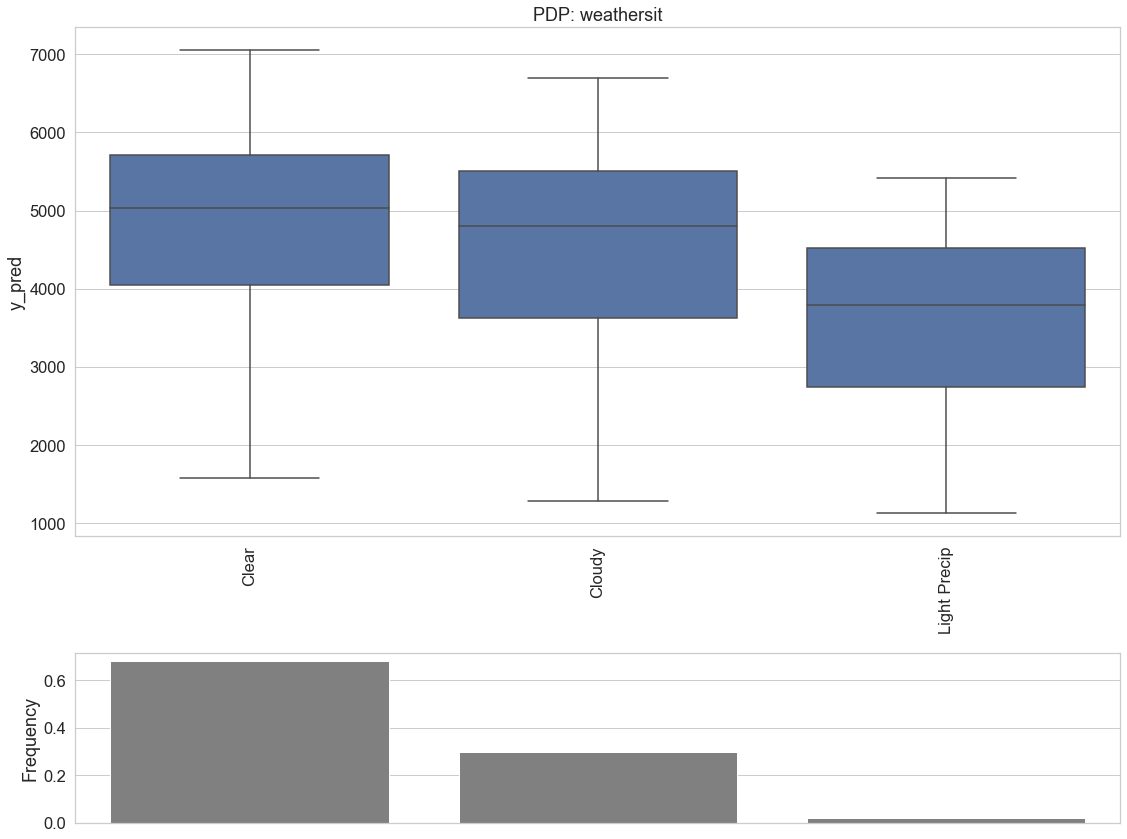

In [501]:
automl.plot_pdp(test, feature_name = 'weathersit')

Report generation

In [503]:
from lightautoml.report.report_deco import ReportDeco

In [504]:
RD = ReportDeco(output_path = 'TabularAutoML_Report')

automl_rd = RD(
    
    TabularAutoML(task = task, 
                  cpu_limit = N_THREADS,
                  reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                  general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})
)

In [505]:
%%time
oof_pred = automl_rd.fit_predict(train, roles = roles)

Wall time: 2min 29s


## Conclusion

In [654]:
final_results.style \
    .highlight_max('r2', color = 'lightgreen') \
    .highlight_min('r2', color = 'red')\
    .highlight_max(['RMSE', 'MAE', 'MAPE'], color = 'red')\
    .highlight_min(['RMSE', 'MAE', 'MAPE'], color = 'lightgreen')\
    .where(lambda val: 'AutoML' in str(val), 'background-color: yellow', subset=['Model'])

,Model,r2,RMSE,MAE,MAPE
0,"AutoML (1hr, multilevel)",0.582715,1236.934613,1088.505232,27.608396
1,"AutoML (20 minutes, multilevel)",0.582589,1237.121003,1090.139478,27.764973
2,Random Forest (tuned),0.582087,1237.865199,1069.528417,28.051760
3,AutoML (10 minutes),0.581427,1238.842395,1093.143252,28.615964
4,AutoML (default train time),0.580046,1240.883736,1090.435306,28.441077
5,CatBoost (tuned),0.579263,1242.040713,1081.442023,27.705847
6,LightGBM (tuned),0.569335,1256.608811,1094.171345,28.637821
7,CatBoost (default),0.564596,1263.504282,1080.628645,27.179839
8,Random Forest (default),0.559479,1270.907274,1085.378163,28.276113
9,Linear Regression,0.517106,1330.626777,1183.931973,31.766967


1. Default AutoML trained in 3 minutes and beat most of the tuned models
2. Longer training time and using more models generally leads to better results, but overfitting could be an issue
3. 'Tuning' of AutoML = playing with
    - \# of models on each level
    - \# of levels
    - types of models used on each level
    - allowed training time
4. Can learn from AutoML
    - Feature importances
    - PDPs
    - Distributions (generated report)

## Few more words about LightAutoML

Classifiaction problems also come with really useful reports: https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop/blob/master/LightAutoML%20demo%20(Blackbox).ipynb

<br>

Can execute the following tasks with the respective losses and metrics:


|Task | Loss | Metrics |
| --- | --- | --- |
|Regression = 'reg' | mse  <br/> mae  <br/> mape  <br/> rmsle  <br/> huber  <br/> fair  <br/> quantile | mse  <br/> mae  <br/> mape  <br/> rmsle  <br/> huber  <br/> fair  <br/> quantile |
|Binary classification = 'binary' | logloss | auc  <br/> accuracy  <br/> logloss |
|Multiclass classification = 'multiclass' | crosstentropy <br/> f1 | crossentropy  <br/> auc  <br/>  auc_mu |

<br>


Can handle all kinds of features:

- NumericRole()
- CategoryRole()
- TextRole()
- DatetimeRole()
- DropRole()
- GroupRole()

<br>

Applicable to NLP problems:


<img src="https://raw.githubusercontent.com/sberbank-ai-lab/lightautoml-datafest-workshop/88e5a53824ff6466c3ac6514708775beefc598ca/imgs/tutorial_NLP_image_1.jpg" width="1000"/>

<img src="https://raw.githubusercontent.com/sberbank-ai-lab/lightautoml-datafest-workshop/88e5a53824ff6466c3ac6514708775beefc598ca/imgs/tutorial_NLP_image_2.jpg" width="1000"/>


Idea: cyclical endocing of month

In [645]:
i = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
cyc_end = lambda k: - np.cos(2 * np.pi * k / 12)

j = [cyc_end(i) for i in i]

<AxesSubplot:>

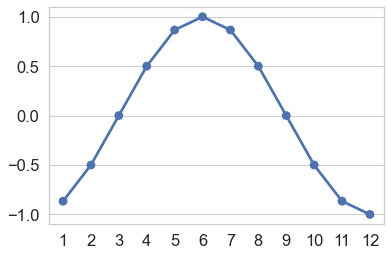

In [658]:
sns.pointplot(i, j)